# Transfer Learning - PyTorch

### Setting up the Frameworks


In [1]:
# Install PyTorch
!pip install --upgrade torch
!pip install --upgrade torchvision

# Import PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Ready to train a model using PyTorch', torch.__version__)

Requirement already up-to-date: torch in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (1.0.1.post2)
  Using cached https://files.pythonhosted.org/packages/fb/01/03fd7e503c16b3dc262483e5555ad40974ab5da8b9879e164b56c1f4ef6f/torchvision-0.2.2.post3-py2.py3-none-any.whl
  Found existing installation: torchvision 0.2.1
Cannot remove entries from nonexistent file /home/nbuser/anaconda3_420/lib/python3.5/site-packages/easy-install.pth
Ready to train a model using PyTorch 1.0.1.post2


### Loading and Preparing the Data

In [9]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, center-crop to 224x224 (to match the resnet image size), and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 18-image batches
    print("Preparing training dataset...")
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
    print(train_size,"images.")
    
    # define a loader for the testing data we can iterate through in 18-image batches
    print("Preparing validation dataset...")
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=False
    )
    print(test_size,"images.")
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
print("Getting Data...")
data_path = 'resized_images/'
train_loader, test_loader = load_dataset(data_path)

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print("class names: ", classes)

Getting Data...
Preparing training dataset...
168 images.
Preparing validation dataset...
72 images.
class names:  ['automobile', 'plane', 'train']


### Downloading a trained model to user as a base

In [3]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nbuser/.torch/models/resnet18-5c106cde.pth
46827520it [00:02, 17840309.40it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Training the Model

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch, "...")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):

        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_training_loss = train_loss / len(train_loader.dataset)
    print("\tTraining set: Average loss: {:.6f}".format(avg_training_loss))
    return avg_training_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    test_loss /= len(test_loader.dataset)
    print('\tValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return test_loss
    
    
# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs
epochs = 5
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1 ...
	Training set: Average loss: 0.244393
	Validation set: Average loss: 0.1548, Accuracy: 59/72 (82%)

Epoch: 2 ...
	Training set: Average loss: 0.161241
	Validation set: Average loss: 0.0907, Accuracy: 70/72 (97%)

Epoch: 3 ...
	Training set: Average loss: 0.129570
	Validation set: Average loss: 0.0646, Accuracy: 72/72 (100%)

Epoch: 4 ...
	Training set: Average loss: 0.113887
	Validation set: Average loss: 0.0501, Accuracy: 72/72 (100%)

Epoch: 5 ...
	Training set: Average loss: 0.104246
	Validation set: Average loss: 0.0409, Accuracy: 72/72 (100%)



### View the Loss History

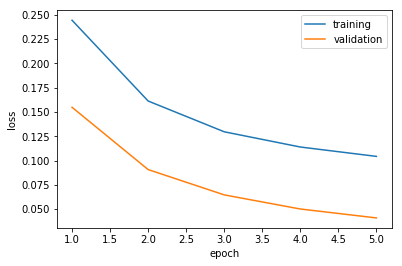

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


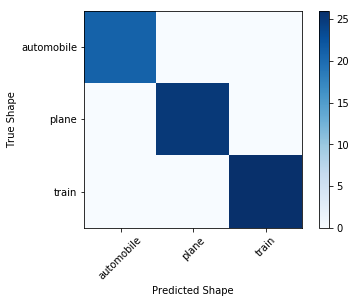

In [8]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
with torch.no_grad():
    for data, target in test_loader:
        for label in target.cpu().data.numpy():
            truelabels.append(label)
        for prediction in model.cpu()(data).data.numpy().argmax(1):
            predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

### Using the Trained Model

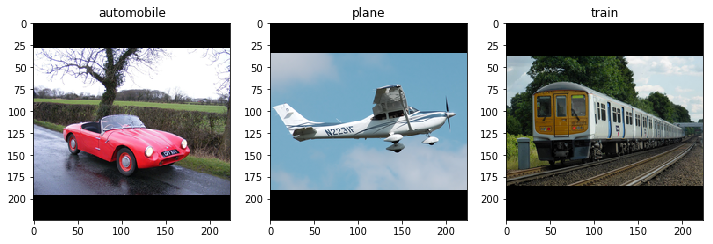

In [7]:
# Helper function to make image square
def reshape_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (0,0,0))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return np.array(newimg)

# Function to predict the class of an image
def predict_image(classifier, image_array):
    from PIL import Image
    
    classifier.to("cpu")
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['automobile', 'plane', 'train']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of each input image
    with torch.no_grad():
        predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/1962_Fairthorpe_Electron_Minor_British_Sports_Car.jpg/1200px-1962_Fairthorpe_Electron_Minor_British_Sports_Car.jpg')
image_urls.append('https://upload.wikimedia.org/wikipedia/commons/9/9e/Cessna182t_skylane_n2231f_cotswoldairshow_2010_arp.jpg')
image_urls.append('https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/319373_and_319_number_438_to_Sevenoaks_2E45_by_Train_Photos.jpg/1200px-319373_and_319_number_438_to_Sevenoaks_2E45_by_Train_Photos.jpg')

size = (224,224)

img_array = []

for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = reshape_image(img, size)
    img_array.append(img)
    
predicted_classes = predict_image(model, np.array(img_array))

fig = plt.figure(figsize=(12, 8))
idx = 0
for predicted_class in predicted_classes:
    a=fig.add_subplot(1,len(image_urls),idx+1)
    img = img_array[idx]
    imgplot = plt.imshow(img)
    a.set_title(predicted_class)
    idx += 1

